# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Loading Categorized Image Data from a `.npz` File
- The function `np.load` is used to load the contents of the `.npz` file, which contains the image data and its corresponding labels and sub-labels.
- The `allow_pickle=True` argument is used to allow loading objects that may have been saved using Python's pickle format, which is necessary for arrays containing non-basic data types.
 
**Loaded Data**:
   - `image_pixels`: The array containing the preprocessed image pixel data.
   - `labels`: The array containing the labels for the images (e.g., `0` for good images, `1` for manipulated images).
   - `sub_labels`: The array containing the sub-labels for the images (e.g., "good", "manipulated_front").

In [2]:
data = np.load('balanced_data.npz', allow_pickle=True)
image_pixels = data['image']
labels = data['label']
sub_labels = data['sub_label']

## Splitting the Dataset

To evaluate the model's performance, the dataset is split into two subsets:
1. **Training Set**: Used to train the model.
2. **Testing Set**: Used to test the model and evaluate its performance.

In [3]:
# Split the dataset into training and testing sets (70% training, 30% testing)
images_train, images_test, labels_train, labels_test = train_test_split(
    image_pixels, labels, test_size=0.3, random_state=42
)


# Shape of the images

In [4]:
input_shape = image_pixels[0].shape
input_shape

(256, 256, 1)

## Model Architecture

This model leverages the power of **InceptionV3** pre-trained on the ImageNet dataset as a feature extractor, which helps capture important visual features without needing to train the model from scratch. It is followed by a simple fully connected (dense) layer for binary classification.

### Model Compilation:

- **Optimizer**: Adam optimizer is used for training, which is popular due to its efficiency and adaptability.
- **Loss Function**: Binary crossentropy loss is used, suitable for binary classification tasks.
- **Metrics**: Accuracy is used as the evaluation metric during training.

In [5]:
# Model architecture
model = models.Sequential()

# Lambda layer to repeat grayscale image into 3 channels (RGB)
model.add(layers.Lambda(lambda x: tf.repeat(x, repeats=3, axis=-1), input_shape=input_shape))

# InceptionV3 as a feature extractor, without the top fully connected layers
inception = InceptionV3(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
inception.trainable = False  # Freeze Inception layers
model.add(inception)

# Add a fully connected layer with 256 units
model.add(layers.Flatten())  # Flatten the output from the InceptionV3 model
model.add(layers.Dense(256, activation='relu'))

# Output layer for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 256)               18874624  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 40677665 (155.17 MB)
Trainable params: 18874881 (72.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


# Training the Model

In [8]:
# Train the model with the callback
history = model.fit(images_train, labels_train, epochs=7, batch_size=32, validation_data=(images_test, labels_test))


Epoch 1/7


15/15 [==============================] - 29s 2s/step - loss: 7.4528 - accuracy: 0.5747 - val_loss: 1.9151 - val_accuracy: 0.6422
Epoch 2/7
15/15 [==============================] - 25s 2s/step - loss: 1.1904 - accuracy: 0.7832 - val_loss: 0.6917 - val_accuracy: 0.8431
Epoch 3/7
15/15 [==============================] - 24s 2s/step - loss: 0.4821 - accuracy: 0.8589 - val_loss: 0.9455 - val_accuracy: 0.7941
Epoch 4/7
15/15 [==============================] - 25s 2s/step - loss: 0.2853 - accuracy: 0.9263 - val_loss: 0.8361 - val_accuracy: 0.7647
Epoch 5/7
15/15 [==============================] - 26s 2s/step - loss: 0.0986 - accuracy: 0.9663 - val_loss: 0.7884 - val_accuracy: 0.7990
Epoch 6/7
15/15 [==============================] - 26s 2s/step - loss: 0.0702 - accuracy: 0.9705 - val_loss: 0.4748 - val_accuracy: 0.8725
Epoch 7/7
15/15 [==============================] - 27s 2s/step - loss: 0.0638 - accuracy: 0.9747 - val_loss: 0.4633 - val_accuracy: 0.8775


## Plotting Training and Validation Loss

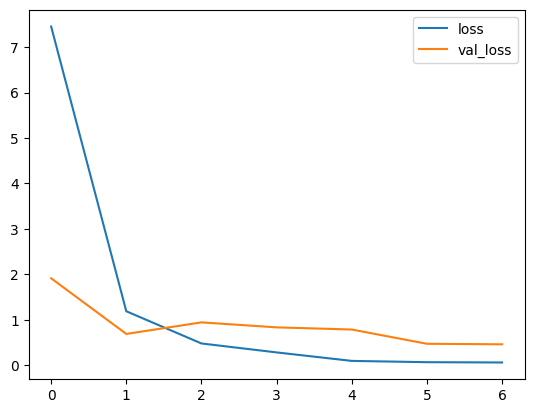

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

## Evaluating Model Performance

In [10]:
# Predicting on the test set
y_hat = model.predict(images_test)

# Applying threshold to make binary predictions (0 or 1)
threshold = 0.5
y_pred = (y_hat > threshold).astype(int)

7/7 [==============================] - 8s 941ms/step


              precision    recall  f1-score   support

           0       0.88      0.88      0.88       103
           1       0.88      0.87      0.88       101

    accuracy                           0.88       204
   macro avg       0.88      0.88      0.88       204
weighted avg       0.88      0.88      0.88       204



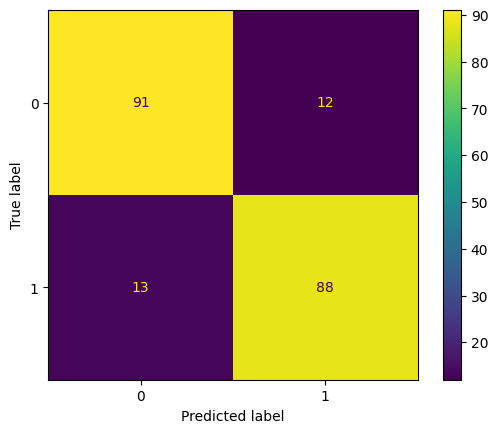

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
print(classification_report(labels_test, y_pred))
ConfusionMatrixDisplay.from_predictions(labels_test, y_pred)